In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Replace SSB's wastewater workflow in TEOTIL3

Miljødirektoratet have tight deadlines for the Oslofjord modelling project. Unfortunately, SSB are not able to provide estimates of discharges from wastewater treatment plants for all parameters in time to meet these deadlines.

The aim of this notebook is to implement an alternative version of SSB's workflow, beginning with more basic datasets.

## 1. Default values per person

Where direct measurements are not available, SSB assumes default nutrient discharges per person per day and estimates nutrient inputs based on the number of people connected to each plant (or type of plant). The default values come from a [book published by Norsk Vann](https://va-kompetanse.no/butikk/laerebok-i-vann-og-avlopsteknikk/). See e-mail from Gisle received 27.03.2025 for a screenshot of the relevant page.

In [2]:
# Default person-specific discharges (g per person per day)
pers_dict = {
    "totn": 12,
    "totp": 1.8,
    "bof5": 60,
    "ss": 70,
}

## 2. Small wastewater treatment plants (<50 p.e.)

As a starting point, SSB can provide estimates of the **number of people** connected to each type of small treatment plant in each kommune. The code in this section aims to:

 1. Recreate SSB's workflow for N and P using the **old** treatment efficiencies to check I can recreate SSB's original results.
    
 2. Update the workflow to use **new** treatment efficiencies recently published by NIBIO.
    
 3. Extend the workflow to include **BOF5** and **SS**.

### 2.1. Old and new treatment efficiencies

SSB's original workflow defines treatment efficiencies only for N and P. See Section 3.3.4 of [this report](https://niva.brage.unit.no/niva-xmlui/handle/11250/2985726) and the references therein for details.

A [recent report](https://nibio.brage.unit.no/nibio-xmlui/handle/11250/3183748) by NIBIO includes updated treatment efficiencies for N and P, as well as proposed efficiencies for BOF5 and SS. The new report suggests ideal treatment efficiencies for properly maintained facilities, but it also provides "reduction factors" by which the ideal efficiencies should be reduced to represent typical conditions (i.e. the real efficiency of normally maintained facilities of average age). Based on the new data, the expected mean efficiency is calculated as:

$$E_{mean} = E_{ideal} (1 - \frac{R}{100})$$

Where $E_{mean}$ is the expected true average efficiency (%); $E_{ideal}$ is the reference or "best case" efficiency for a well maintained facility (%); and $R$ is the efficiency reduction factor (%).

The old and new efficiencies for each "small" treatment type can be found in `treatment_efficiencies_small_wastewater.csv`.

In [3]:
# Read treatment efficiency data
eff_csv = "../../../data/treatment_efficiencies_small_wastewater.csv"
eff_df = pd.read_csv(eff_csv)
eff_df.head()

,ssb_code,ssb_desc,teotil_type,totn_eff_old_pct,totp_eff_old_pct,totn_eff_new_pct,totp_eff_new_pct,bof5_eff_new_pct,ss_eff_new_pct,totn_redfac_new_pct,totp_redfac_new_pct,bof5_redfac_new_pct,ss_redfac_new_pct
0,FASTBOURENS2,Urenset utslipp,Direkte utslipp,0,0,0,0,0,0,0,0,0,0
1,FASTBOSLAM2,Slamavskiller uten etterfiltrering,Slamavskiller,5,5,10,10,25,60,25,25,25,25
2,FASTBOINFILT2,Slamavskiller med infiltrasjon (stedegne masser),Infiltrasjonsanlegg,20,75,40,90,90,100,10,20,10,5
3,FASTBOSAND2,Slamavskiller med sandfilter (tilførte masser),Sandfilteranlegg,15,15,30,75,90,95,10,75,20,10
4,FASTBOBIO2,Minirenseanlegg - biologisk,Biologisk,10,15,30,60,90,80,10,20,10,20


### 2.2. Recreate old workflow for N and P

Checking I can correctly reproduce SSB's old workflow for N and P.

In [4]:
# Read SSB data. The data sent by Gisle in 2023 (for 2002 to 2022) is the last dataset
# based on the "old" treatment efficiencies, so use this for comparison
fpath = r"/home/jovyan/shared/common/teotil3/point_data/historic_data_delivered_2023/tmp_teotil_smaa_anlegg_2002_2022.sdv"
df = pd.read_csv(fpath, sep=";", encoding="cp1252")

for idx, row in eff_df.iterrows():
    site_type = row["ssb_code"]
    df[site_type] = df[site_type].fillna(0)
    for par in ["n", "p"]:
        # Get old treatment efficiency
        treat_eff = row[f"tot{par}_eff_old_pct"] / 100

        # Estimate discharge
        df[f"{par.upper()}_Est_{site_type}"] = (
            365 * df[site_type] * pers_dict[f"tot{par}"] * (1 - treat_eff) / 1000
        )
        df[f"{par.upper()}_{site_type}"] = df[f"{par.upper()}_{site_type}"].fillna(0)

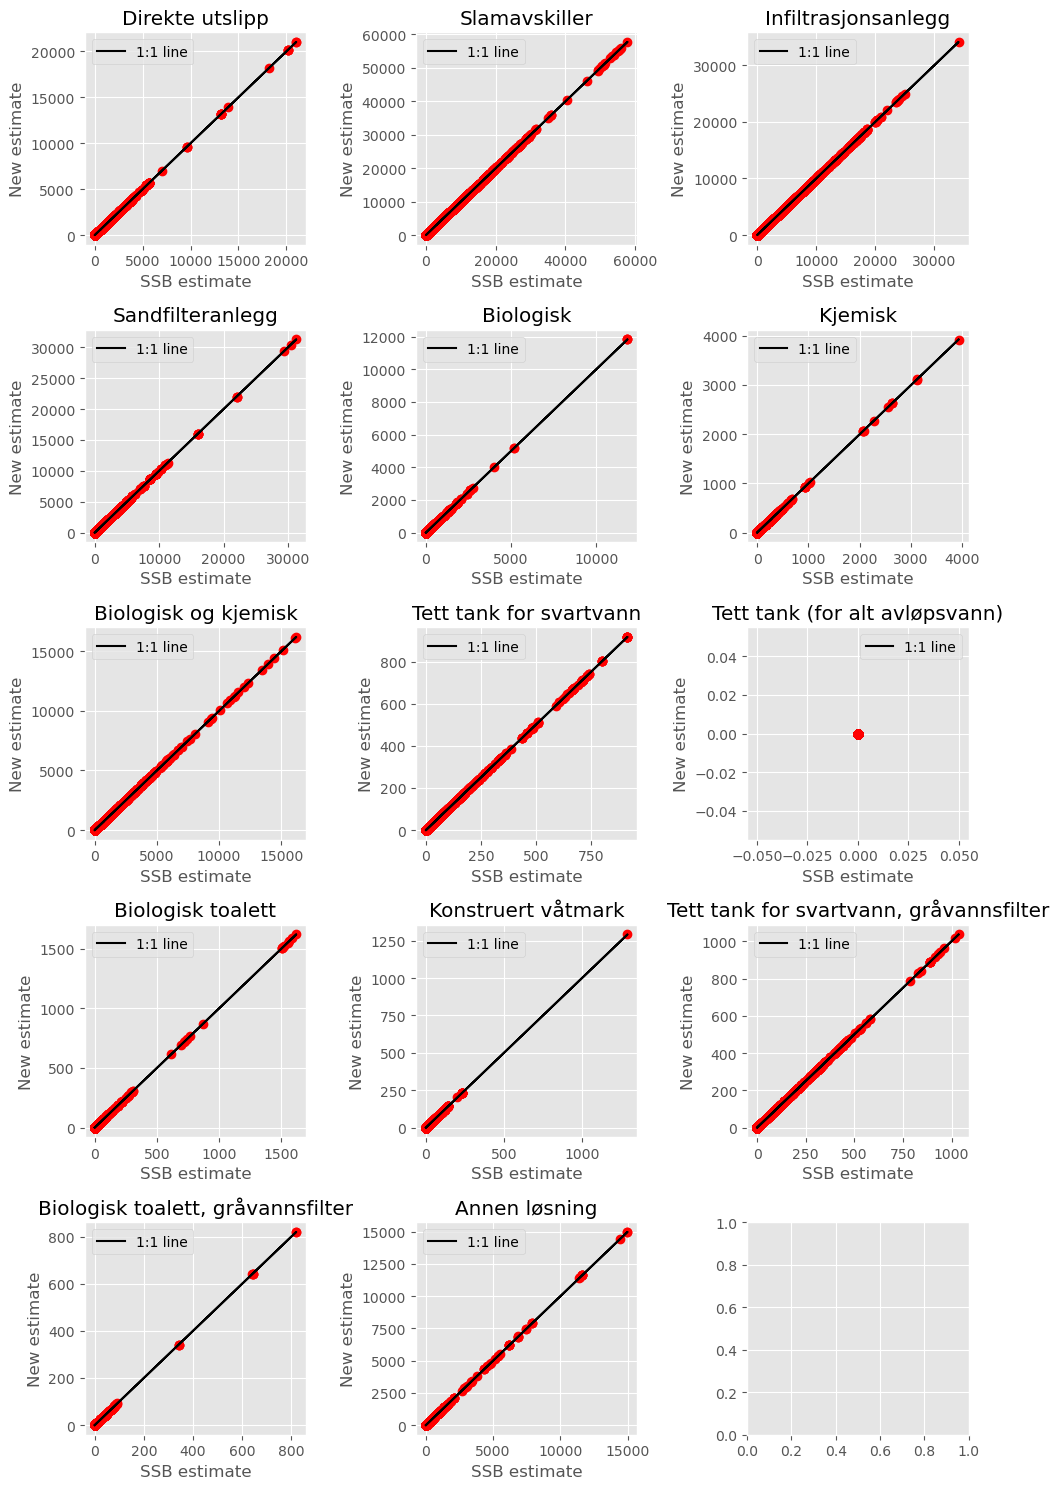

In [5]:
# Plot SSB values against new estimates
par = "n"

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 15))
axes = axes.flatten()

for idx, row in eff_df.iterrows():
    site_type = row["ssb_code"]
    teo_type = row["teotil_type"]
    axes[idx].plot(
        df[f"{par.upper()}_{site_type}"], df[f"{par.upper()}_Est_{site_type}"], "ro"
    )
    axes[idx].plot(
        df[f"{par.upper()}_{site_type}"],
        df[f"{par.upper()}_{site_type}"],
        "k-",
        label="1:1 line",
    )
    axes[idx].set_xlabel("SSB estimate")
    axes[idx].set_ylabel("New estimate")
    axes[idx].set_title(teo_type)
    axes[idx].legend()
plt.tight_layout()

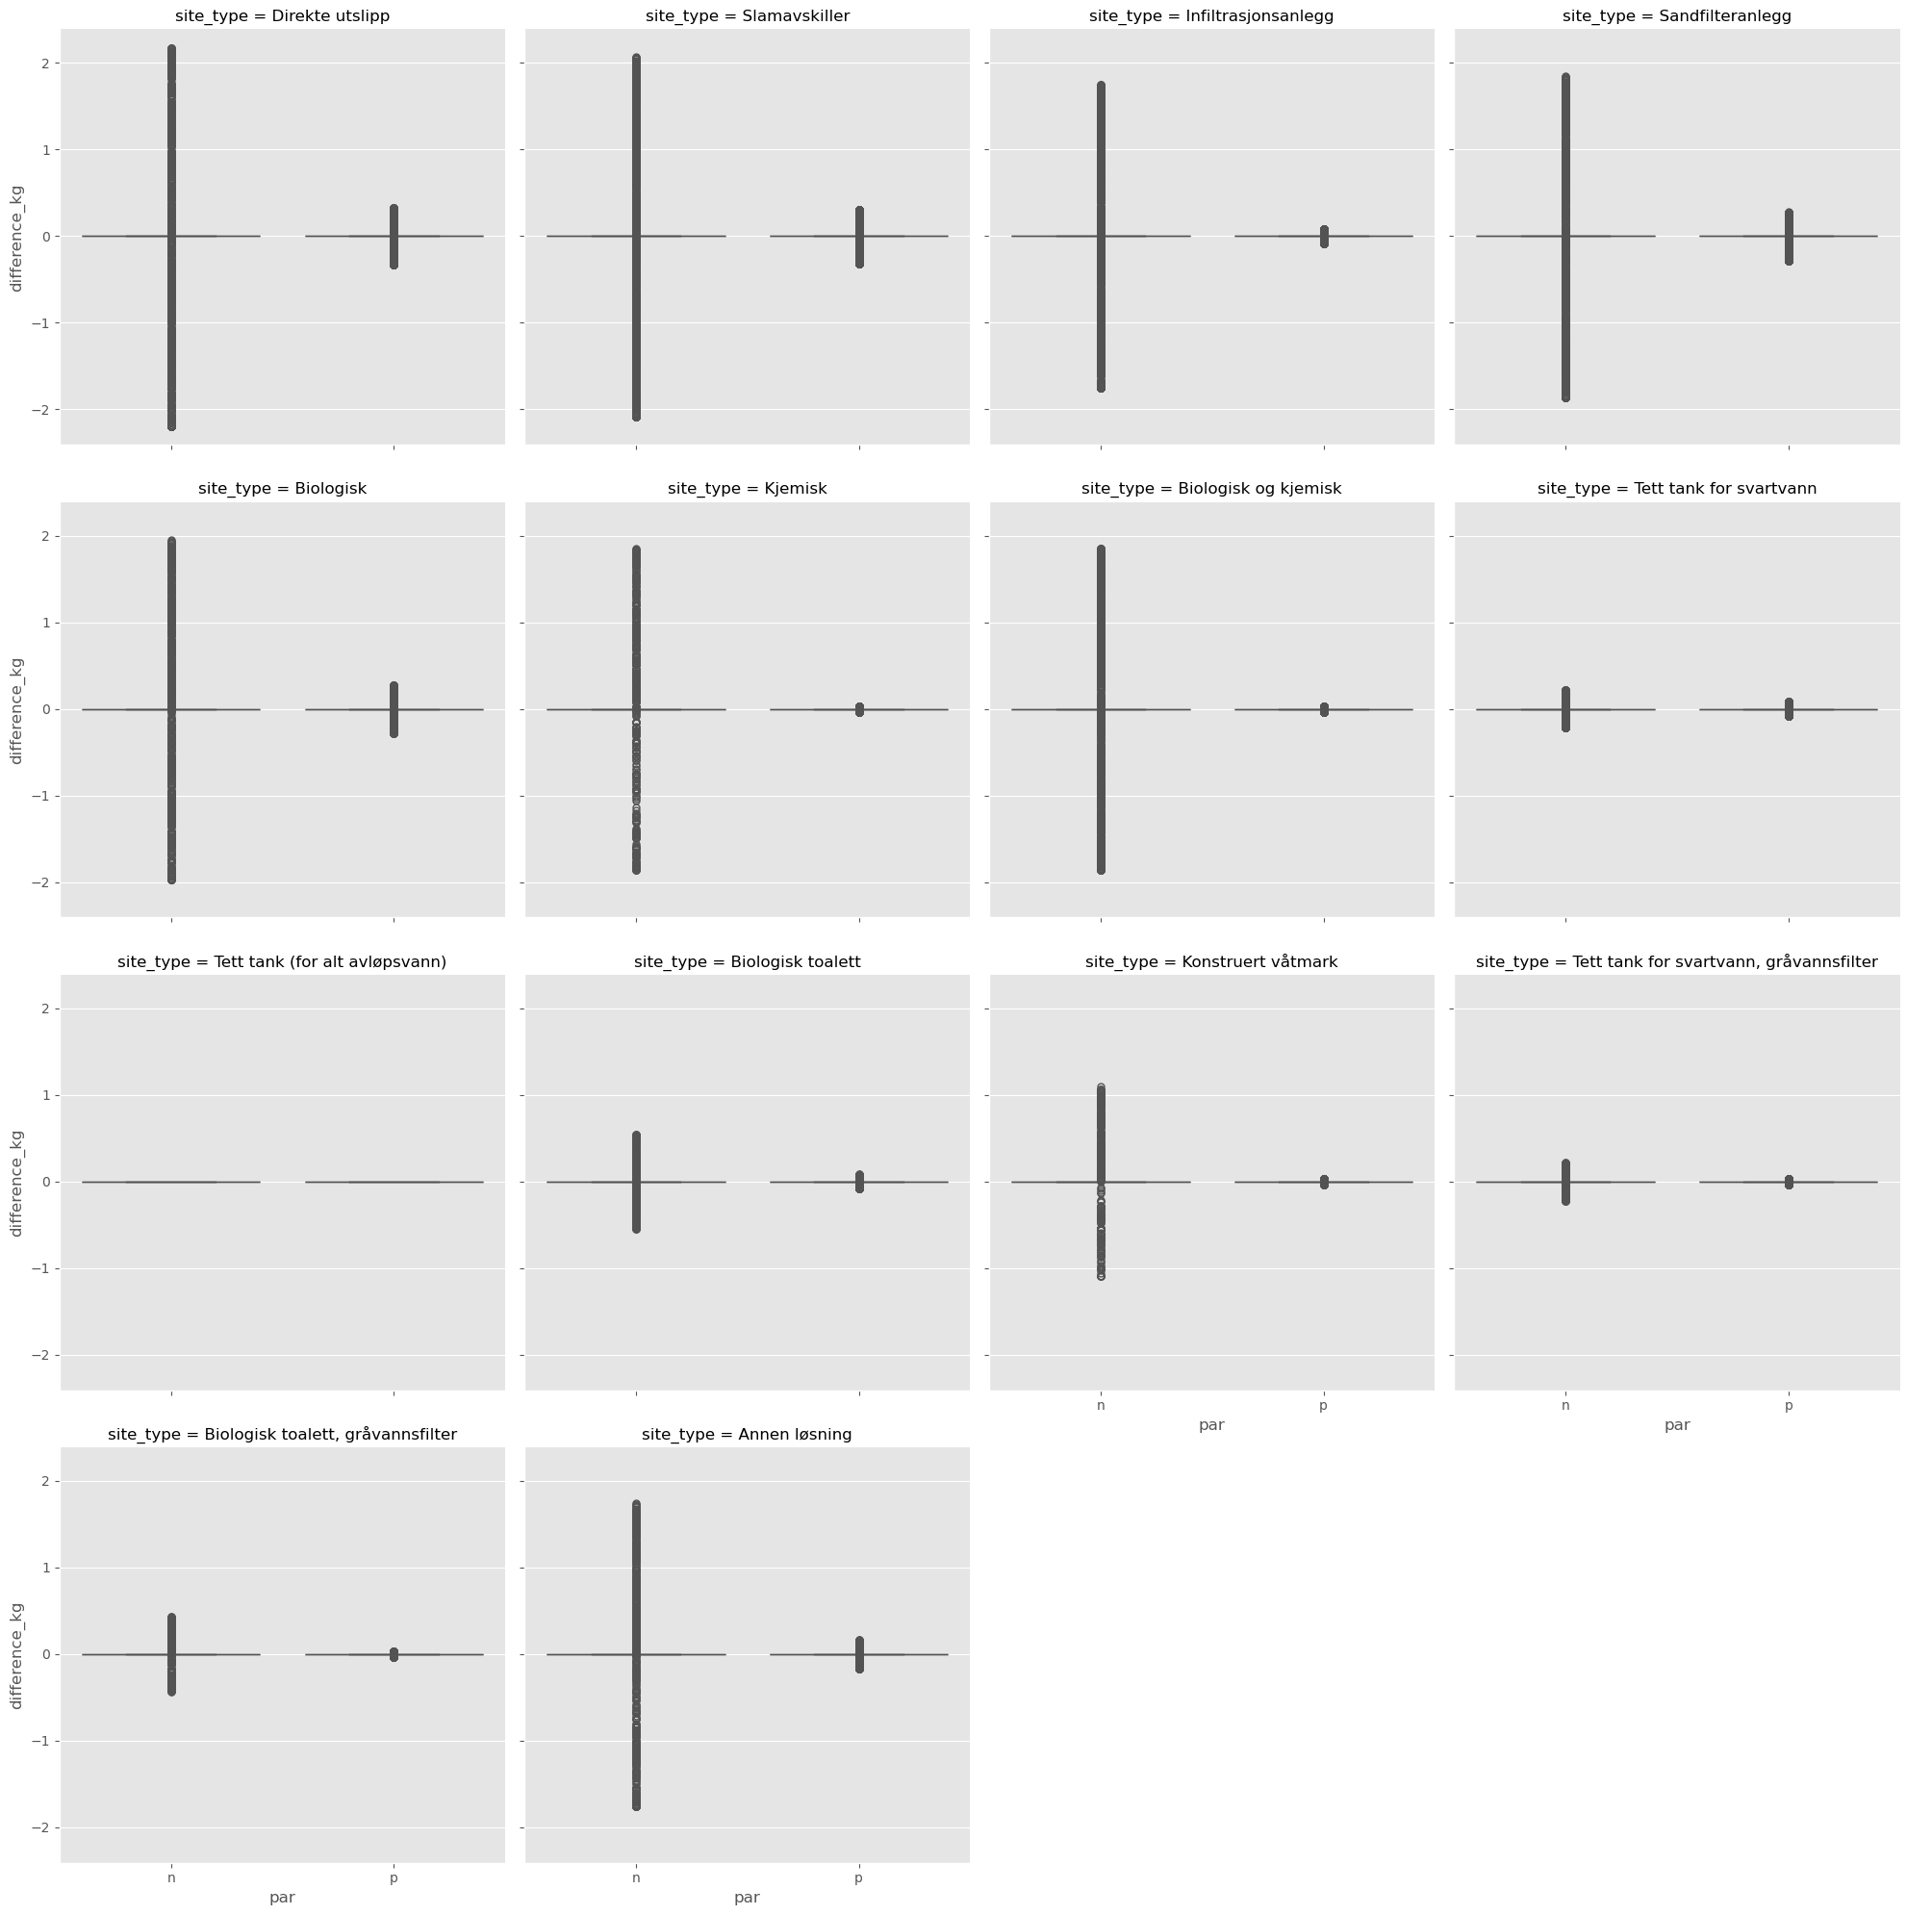

In [6]:
# Plot distribution of differences for each par
df_list = []
for idx, row in eff_df.iterrows():
    site_type = row["ssb_code"]
    teo_type = row["teotil_type"]
    for par in ["n", "p"]:
        # Difference between SSB estimates and new estimates
        diffs = pd.DataFrame(
            df[f"{par.upper()}_{site_type}"] - df[f"{par.upper()}_Est_{site_type}"]
        )
        diffs["par"] = par
        diffs["type"] = teo_type
        diffs.columns = ["difference_kg", "par", "site_type"]
        df_list.append(diffs)
diff_df = pd.concat(df_list, axis="rows")

# Boxplots of differences
sn.catplot(
    data=diff_df,
    x="par",
    y="difference_kg",
    col="site_type",
    col_wrap=4,
    kind="box",
)

The plots above show that my estimates for N and P discharges are identical to those from SSB in most cases, except for a small number of "outliers". However, even for these, differences for N are less than ±2 kg, and for P they're less than ±0.5 kg. In other words, the datasets are the same from a practical perspective.

### 2.3. Update N and P discharges and add BOF5 and SS

This section estimates kommune-level losses of N and P from each site type using the **new** treatment efficiencies from NIBIO (including a correction based on the new "reduction factors"). It also **adds BOF5 and SS** using the same methodology.

In [7]:
# Read latest SSB data. These calculations only use population estimates from SSB,
# so we can use the latest dataset
fpath = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2024/tmp_teotil_smaa_anlegg_2002_2023.sdv"
df = pd.read_csv(fpath, sep=";", encoding="cp1252")

for idx, row in eff_df.iterrows():
    site_type = row["ssb_code"]
    df[site_type] = df[site_type].fillna(0)
    for par, pers_contrib in pers_dict.items():
        # Estimate typical efficiency, allowing for reduction factors
        red_fac = row[f"{par}_redfac_new_pct"] / 100
        treat_eff = row[f"{par}_eff_new_pct"] * (1 - red_fac) / 100

        # Estimate discharge
        df[f"TEO3_{par.upper()}_{site_type}"] = (
            365 * df[site_type] * pers_contrib * (1 - treat_eff) / 1000
        )

# Just cols of interest
cols = ["KOMMUNE_NR", "KOMMUNE_NAVN", "aargang"] + [
    col for col in df.columns if col.startswith("TEO3_")
]
df = df[cols]
df.columns = [col.upper() for col in cols]

df.head()

,KOMMUNE_NR,KOMMUNE_NAVN,AARGANG,TEO3_TOTN_FASTBOURENS2,TEO3_TOTP_FASTBOURENS2,TEO3_BOF5_FASTBOURENS2,TEO3_SS_FASTBOURENS2,TEO3_TOTN_FASTBOSLAM2,TEO3_TOTP_FASTBOSLAM2,TEO3_BOF5_FASTBOSLAM2,...,TEO3_BOF5_FASTBOTANKFILTER2,TEO3_SS_FASTBOTANKFILTER2,TEO3_TOTN_FASTBOBIOLTOALETTFILTER2,TEO3_TOTP_FASTBOBIOLTOALETTFILTER2,TEO3_BOF5_FASTBOBIOLTOALETTFILTER2,TEO3_SS_FASTBOBIOLTOALETTFILTER2,TEO3_TOTN_FASTBOANNEN2,TEO3_TOTP_FASTBOANNEN2,TEO3_BOF5_FASTBOANNEN2,TEO3_SS_FASTBOANNEN2
0,101,Halden,2002,560.64,84.096,2803.2,3270.4,6547.2240,982.083600,28754.70000,...,3826.4775,3078.775,0.0,0.0,0.0,0.0,0.0000,0.00000,0.000,0.0000
1,104,Moss,2002,0.00,0.000,0.0,0.0,356.5320,53.479800,1565.85000,...,0.0000,0.000,0.0,0.0,0.0,0.0,89.7900,9.03375,301.125,351.3125
2,105,Sarpsborg,2002,0.00,0.000,0.0,0.0,9751.9605,1462.794075,42829.55625,...,2734.1055,2199.855,0.0,0.0,0.0,0.0,0.0000,0.00000,0.000,0.0000
3,106,Fredrikstad,2002,0.00,0.000,0.0,0.0,10465.0245,1569.753675,45961.25625,...,0.0000,0.000,0.0,0.0,0.0,0.0,0.0000,0.00000,0.000,0.0000
4,111,Hvaler,2002,0.00,0.000,0.0,0.0,0.0000,0.000000,0.00000,...,0.0000,0.000,0.0,0.0,0.0,0.0,4457.1756,448.43535,14947.845,17439.1525


## 3. Large wastewater treatment plants (≥ 50 p.e.)

### 3.1. Explore raw data from Miljødirektoratet

Torstein has sent raw data for wastewater exported from MDir's database (see e-mail received 12.02.2025 for details). The data require some restructuring before further processing.

In [8]:
# Basic site details
xl_path = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2025/mdir_wastewater_data/AnleggSøk2025.02.12.xlsx"
site_df = pd.read_excel(xl_path, sheet_name="Treffliste", skiprows=9)

col_dict = {
    "Anleggsnr.": "anlegg_nr",
    "Navn på anlegg": "anlegg_name",
    "Anleggsaktivitet": "activity",
    "Kommune": "kommune",
    "Fylke": "fylke",
    "Sone (lok.)": "site_utm_zone",
    "Øst (lok.)": "site_east",
    "Nord (lok.)": "site_north",
    "Sone (utslipp)": "outflow_utm_zone",
    "Øst (utslipp)": "outflow_east",
    "Nord (utslipp)": "outflow_north",
    "Kilderefnr.": "kilderefnr",
}
site_df.rename(columns=col_dict, inplace=True)
site_df = site_df[col_dict.values()]

site_df.head()

,anlegg_nr,anlegg_name,activity,kommune,fylke,site_utm_zone,site_east,site_north,outflow_utm_zone,outflow_east,outflow_north,kilderefnr
0,0301.0979.01,Bekkelaget renseanlegg med tilførselstuneller ...,Avløpsnett og -rensing,Oslo,Oslo,32.0,599070.0,6639810.0,32.0,598452.0,6639512.0,0301AL01
1,0301.0980.01,Grefsenkollen renseanlegg,Privat avløpsanlegg,Oslo,Oslo,32.0,600735.0,6648092.0,32.0,600716.0,6648087.0,0301AL27
2,0301.0981.01,Kobberhaugshytta,Privat avløpsanlegg,Oslo,Oslo,32.0,592687.0,6656598.0,32.0,592733.0,6656625.0,0301AL30
3,0301.0983.01,"Mariholtet sportsstue, renseanlegg",Privat avløpsanlegg,Oslo,Oslo,32.0,606758.0,6640823.0,32.0,606767.0,6640809.0,0301AL14
4,0301.0984.01,Skar renseanlegg (Nedlagt),Avløpsnett og -rensing,Oslo,Oslo,32.0,599200.0,6655800.0,32.0,599200.0,6655800.0,0301AL06


In [9]:
# Additional site details (file 1)
xl_path = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2025/mdir_wastewater_data/Anleggsdata - Avløp 12.02.2025.xlsx"
prop_df1 = pd.read_excel(xl_path, sheet_name="Sheet1", skiprows=9)

# Just focus on design capacity for now
prop_df1 = prop_df1[prop_df1["Spørsmål"] == "Dimensjonerende kapasitet, i pe"]

col_dict = {
    "År": "year",
    "AnleggNummer": "anlegg_nr",
    "Verdi": "capacity",
}
prop_df1.rename(columns=col_dict, inplace=True)
prop_df1 = prop_df1[col_dict.values()]

# Additional site details (file 2)
xl_path = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2025/mdir_wastewater_data/Anleggsdata 2 - Avløp 12.02.2025.xlsx"
prop_df2 = pd.read_excel(xl_path, sheet_name="Sheet1", skiprows=9)

col_dict = {
    "År": "year",
    "AnleggNummer": "anlegg_nr",
    "Renseprinsipp": "type",
}
prop_df2.rename(columns=col_dict, inplace=True)
prop_df2 = prop_df2[col_dict.values()]

# Merge
prop_df = pd.merge(prop_df1, prop_df2, on=["year", "anlegg_nr"], how="inner").dropna(
    how="any"
)

prop_df.head()

,year,anlegg_nr,capacity,type
0,2024,0301.0983.01,72.0,Naturbasert
1,2024,0301.0985.01,74.0,Kjemisk-biologisk
2,2024,1103.0616.01,90.0,Mekanisk - slamavskiller
3,2024,1112.0024.01,56.0,Mekanisk - slamavskiller
4,2024,1112.0026.01,250.0,Kjemisk-biologisk


In [10]:
# Discharge data
xl_path = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2025/mdir_wastewater_data/Årlig utslipp - Avløp 12.02.2025.xlsx"
dis_df = pd.read_excel(xl_path, sheet_name="Sheet1", skiprows=9)

# Just pars of interest
par_dict = {
    "fosfor, total": "totp",
    "nitrogen, totalt": "totn",
    "biokjemisk oksygenforbruk (BOF), 5 døgn": "bof5",
    "kjemisk oksygenforbruk (KOF)": "kof",
    "suspendert stoff": "ss",
}
par_list = list(par_dict.keys())
dis_df = dis_df.query("Stoff in @par_list")
dis_df["Stoff"] = dis_df["Stoff"].replace(par_dict)

col_dict = {
    "År": "year",
    "AnleggNummer": "anlegg_nr",
    "Stoff": "par",
    "Tilført mengde": "in_tonnes",
    "Utslippsmengde": "out_tonnes",
    "Grunnlag for utslippet": "method",
}
dis_df.rename(columns=col_dict, inplace=True)
dis_df = dis_df[col_dict.values()]

dis_df["method"] = dis_df["method"].fillna("Unknown")

dis_df.head()

,year,anlegg_nr,par,in_tonnes,out_tonnes,method
4,2023,0301.0979.01,kof,21019.020825,1729.099058,Målt
5,2023,0301.0979.01,totn,1620.158622,371.749824,Målt
7,2023,0301.0979.01,totp,200.748793,14.810114,Målt
10,2023,0301.0979.01,bof5,6691.982851,321.342939,Målt
17,2022,0301.0979.01,bof5,7298.990666,158.078989,Målt


In [11]:
# Pivot to wide
dis_df = dis_df.pivot_table(
    index=["year", "anlegg_nr", "method"],
    columns="par",
    values=["in_tonnes", "out_tonnes"],
)
dis_df.columns = [f"{col[1]}_{col[0]}" for col in dis_df.columns]
dis_df.reset_index(inplace=True)
dis_df

,year,anlegg_nr,method,bof5_in_tonnes,kof_in_tonnes,ss_in_tonnes,totn_in_tonnes,totp_in_tonnes,bof5_out_tonnes,kof_out_tonnes,ss_out_tonnes,totn_out_tonnes,totp_out_tonnes
0,2010,0301.0979.01,Målt,7378.308128,18562.913291,NaN,1328.24900,NaN,526.710061,1461.364028,NaN,407.903000,NaN
1,2010,1101.0039.01,Målt,352.993707,938.784600,461.726485,NaN,NaN,193.523357,823.241880,152.871905,NaN,NaN
2,2010,1106.0048.01,Målt,NaN,NaN,NaN,1.62500,0.169240,NaN,NaN,NaN,1.126000,0.064700
3,2010,1106.0051.01,Målt,45.575000,125.166667,81.925000,6.65000,1.442000,13.100000,42.333333,13.100000,4.583000,0.467500
4,2010,1106.0057.01,Målt,1321.425857,2181.685184,1178.904541,169.17200,16.090000,1376.860968,2181.685174,1178.904541,169.172000,16.090000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25168,2024,5542.0012.01,Estimert,52.646400,105.292800,NaN,10.52928,1.579392,42.117120,68.440320,NaN,8.949888,1.342483
25169,2024,5542.0013.01,Estimert,4.380000,8.760000,NaN,0.87600,0.131400,3.504000,5.694000,NaN,0.744600,0.111690
25170,2024,5542.0014.01,Estimert,2.478000,4.956000,NaN,0.49560,0.074340,2.478000,4.956000,NaN,0.495600,0.074340
25171,2024,5624.0019.01,Estimert,1.314000,2.628000,NaN,0.26280,0.039420,1.051200,1.314000,NaN,0.223380,0.033507


In [12]:
cols = [
    "anlegg_nr",
    "kilderefnr",
    "anlegg_name",
    "activity",
    "kommune",
    "fylke",
    "site_utm_zone",
    "site_east",
    "site_north",
    "outflow_utm_zone",
    "outflow_east",
    "outflow_north",
    "capacity",
    "type",
    "year",
    "method",
    "bof5_in_tonnes",
    "bof5_out_tonnes",
    "kof_in_tonnes",
    "kof_out_tonnes",
    "ss_in_tonnes",
    "ss_out_tonnes",
    "totn_in_tonnes",
    "totn_out_tonnes",
    "totp_in_tonnes",
    "totp_out_tonnes",
]
for year in range(2013, 2014):
    ann_dis_df = dis_df.query("year == @year").copy()
    ann_prop_df = prop_df.query("year == @year").copy()
    ann_df = pd.merge(ann_dis_df, ann_prop_df, on=["year", "anlegg_nr"], how="left")
    ann_df = pd.merge(ann_df, site_df, on="anlegg_nr", how="left")
    ann_df = ann_df[cols]

In [13]:
ann_df.to_excel("test.xlsx", index=False)